In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
import matplotlib
from statsmodels.graphics.tsaplots import plot_pacf
from itertools import product 
import subprocess
import sys

In [25]:
df = pd.read_csv('Geochemical Checklist.csv', sep=',') # leemos el archivo csv
pd.set_option('display.max_columns', None) # lo que realizamos aquí es que se muestren todas las columnas
print(df.head(5)) # mostramos las primeras 5 filas

  Project Despach N° RA-20XX-XXXX SampleID_Init SampleID_Fin  Total Sample SE  \
0    BRAL            RA-2022-0013     BR1001081    BR1001082                2   
1    BRAL            RA-2022-0024     BR1001382    BR1001385                4   
2    BRAL            RA-2022-0025     BR1001533    BR1001545               13   
3    BRAL            RA-2022-0027     BR1000554    BR1000563               10   
4    BRAL            RA-2022-0035     BR1001546    BR1001553                8   

   Weight SE SampleType         Target Laboratory Prepared Method  \
0       5.87   RockChip    Aurora West        ALS         PREP-31   
1      11.89   RockChip  Varzea Alegre        ALS         PREP-31   
2      52.59       Soil  Varzea Alegre        ALS         PREP-31   
3      41.59  StreamSed   Farias Brito        ALS         PREP-41   
4      20.96       Soil  Varzea Alegre        ALS         PREP-31   

           Analytical Method DispatchDate Over Limit Analytes ReceivedDate  \
0           ME-MS61L

In [26]:
# Eliminamos las columnas que no necesitamos (FLSLoggedBy,FLSLoggedDate,FLSExported,MetadataID) si existen
columns_to_drop = ['FLSLoggedBy', 'FLSLoggedDate', 'FLSExported', 'MetadataID']
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns], axis=1)

In [27]:
#contamos los rows que corresponden al Analytical Method = TRSPEC-20
print(df[df['Analytical Method'] == 'TRSPEC-20'].shape[0])

#eliminamos esos dos ROWS ya que no corresponde a los datos que necesitamos.
df = df[df['Analytical Method'] != 'TRSPEC-20']


2


In [28]:
#mostramos las columnas que tenemos y su tipo de dato
print(df.dtypes)

Project                     object
Despach N° RA-20XX-XXXX     object
SampleID_Init               object
SampleID_Fin                object
Total Sample SE              int64
Weight SE                  float64
SampleType                  object
Target                      object
Laboratory                  object
Prepared Method             object
Analytical Method           object
DispatchDate                object
Over Limit                  object
Analytes                    object
ReceivedDate                object
ResultDate                  object
Workorder                   object
Location                    object
Responsible                 object
dtype: object


In [29]:
#transformamos las fechas a tipo datetime (dispatchDate, ReceivedDate,Resultdate) mes,dia,año
df['DispatchDate'] = pd.to_datetime(df['DispatchDate'])
df['ReceivedDate'] = pd.to_datetime(df['ReceivedDate'])
df['ResultDate'] = pd.to_datetime(df['ResultDate'])
print(df.dtypes)

Project                            object
Despach N° RA-20XX-XXXX            object
SampleID_Init                      object
SampleID_Fin                       object
Total Sample SE                     int64
Weight SE                         float64
SampleType                         object
Target                             object
Laboratory                         object
Prepared Method                    object
Analytical Method                  object
DispatchDate               datetime64[ns]
Over Limit                         object
Analytes                           object
ReceivedDate               datetime64[ns]
ResultDate                 datetime64[ns]
Workorder                          object
Location                           object
Responsible                        object
dtype: object


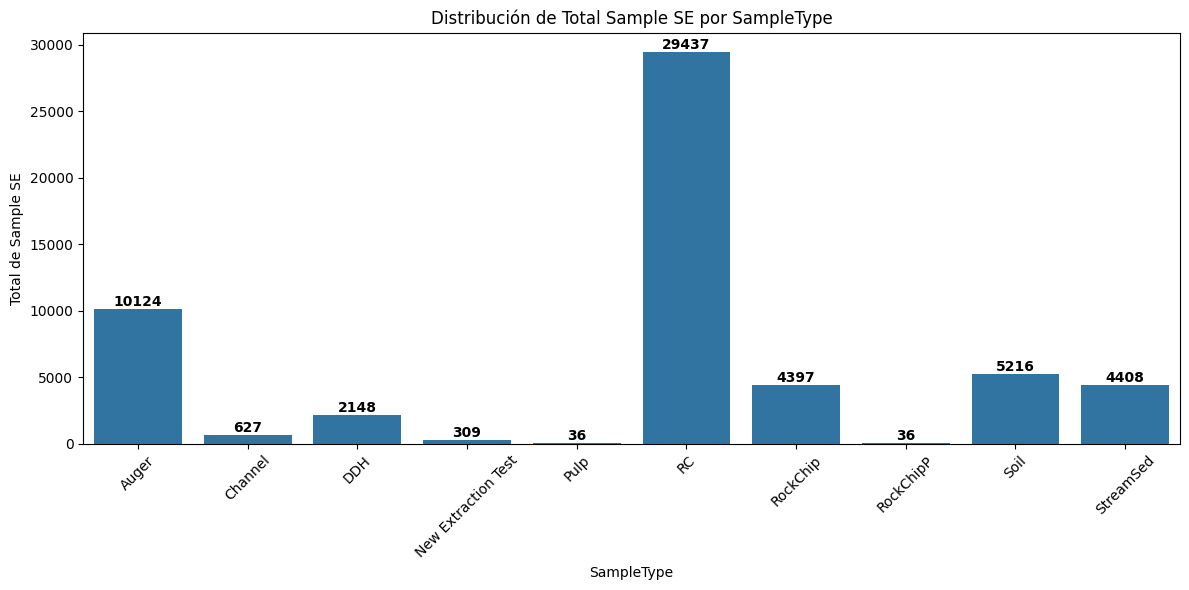

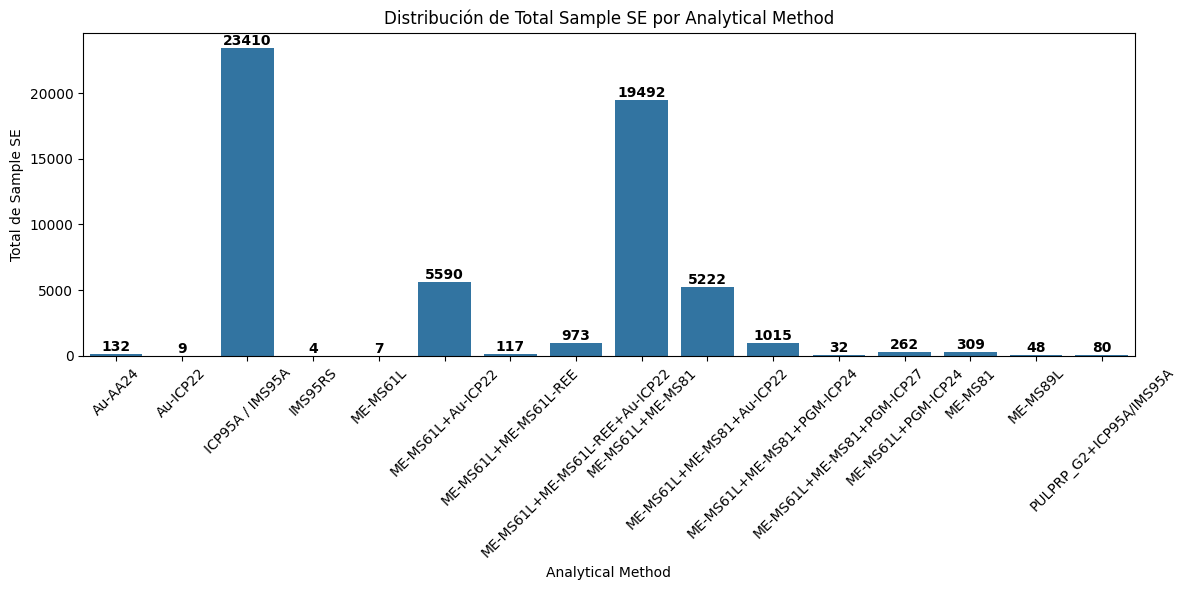

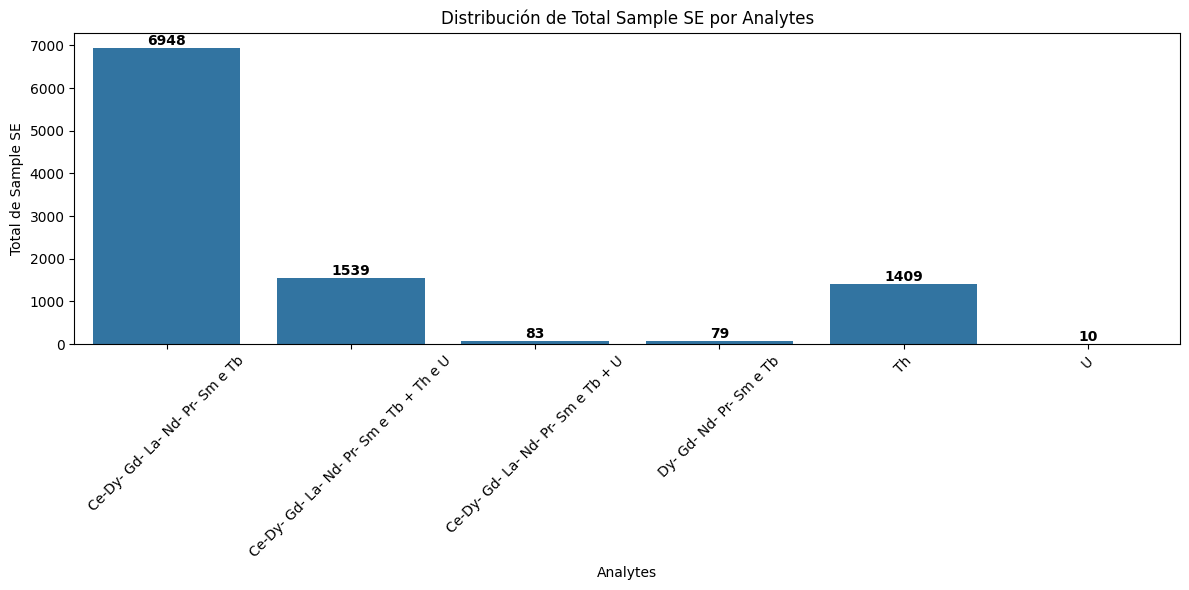

In [30]:

# Lista de columnas para las que queremos graficar la distribución de Total Sample SE
columns = ['SampleType', 'Analytical Method', 'Analytes']

# Iterar sobre cada columna y generar el gráfico correspondiente
for col in columns:
    # Agrupar por la columna actual y sumar Total Sample SE
    df_grouped = df.groupby(col)['Total Sample SE'].sum().reset_index()
    
    # Crear el gráfico de barras
    plt.figure(figsize=(12, 6))
    sns.barplot(x=col, y='Total Sample SE', data=df_grouped)
    
    # Agregar etiquetas de los valores en cada barra
    for index, row in df_grouped.iterrows():
        plt.text(index, row['Total Sample SE'], f"{int(row['Total Sample SE'])}", 
                 ha='center', va='bottom', fontweight='bold')
    
    # Personalizar etiquetas y título
    plt.xlabel(col)
    plt.ylabel('Total de Sample SE')
    plt.title(f'Distribución de Total Sample SE por {col}')
    plt.xticks(rotation=45)  # Rotar etiquetas del eje X para mayor legibilidad
    plt.tight_layout()  # Ajustar el layout para evitar recortes
    plt.show()



In [31]:
# Creamos una variable df_2 que contenga solo TotalSample_SE y dispatchdate

df_dispatchdate = df[['Total Sample SE', 'DispatchDate']]
print(df_dispatchdate.head(5))
print(df_dispatchdate.dtypes)

   Total Sample SE DispatchDate
0                2   2022-05-16
1                4   2022-06-27
2               13   2022-06-27
3               10   2022-06-27
4                8   2022-07-13
Total Sample SE             int64
DispatchDate       datetime64[ns]
dtype: object


              Total Sample SE
DispatchDate                 
2021-11-22                144
2021-11-30                 81
2021-12-17                 84
2022-01-13                 26
2022-01-24                 99


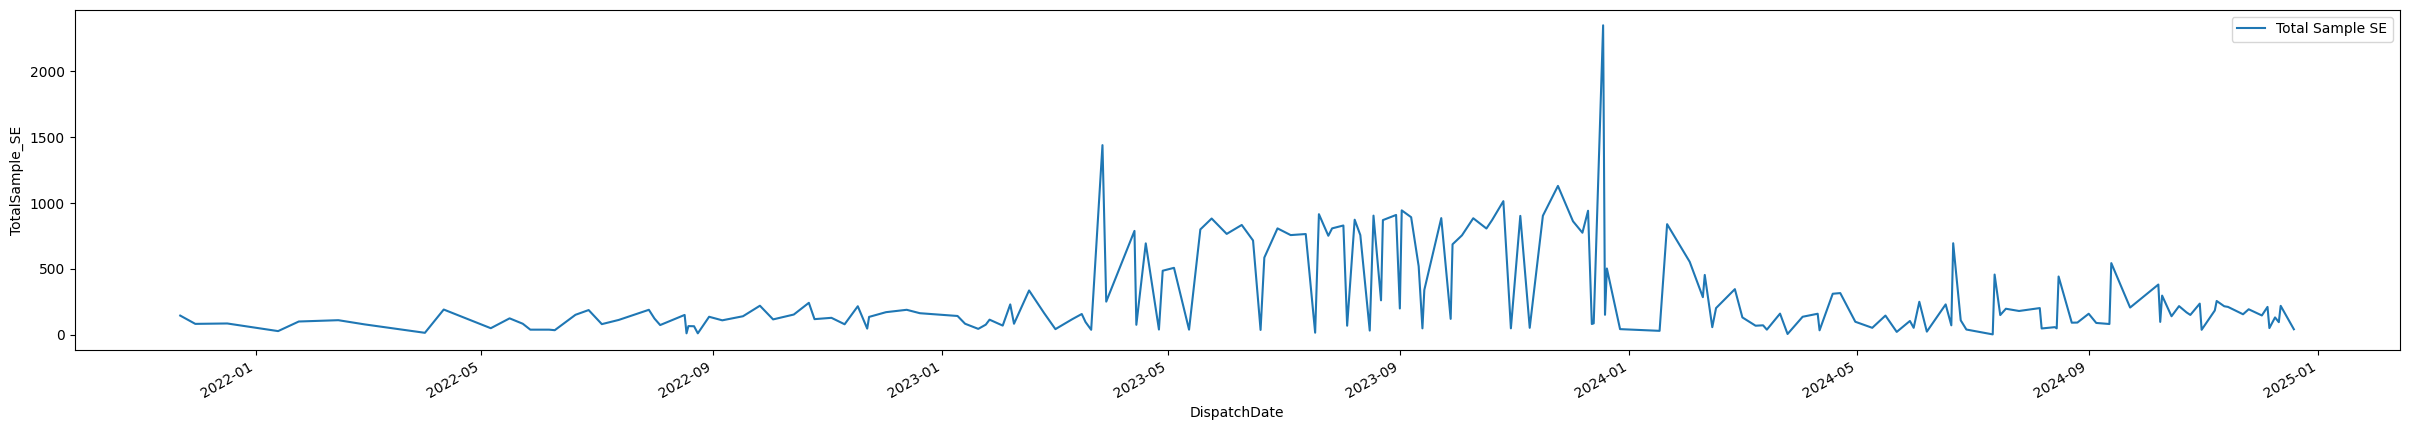

In [32]:
# Agrupamos la sumatoria de TotalSample_SE en las mismas fechas
df_dispatchdate_agrupado = df_dispatchdate.groupby('DispatchDate').sum()
print(df_dispatchdate_agrupado.head(5))

# Graficamos
df_dispatchdate_agrupado.plot(figsize=(30, 5))
plt.xlabel('DispatchDate')
plt.ylabel('TotalSample_SE')
plt.show()

In [33]:
df_receiveddate = df[['Total Sample SE', 'ReceivedDate']]
print(df_receiveddate.head(5))
print(df_receiveddate.dtypes)

   Total Sample SE ReceivedDate
0                2   2022-05-24
1                4   2022-06-30
2               13   2022-06-30
3               10   2022-06-30
4                8   2022-07-19
Total Sample SE             int64
ReceivedDate       datetime64[ns]
dtype: object


              Total Sample SE
ReceivedDate                 
2021-12-03                144
2021-12-13                 81
2022-01-05                 84
2022-01-24                 26
2022-01-31                 99


<Axes: xlabel='ReceivedDate'>

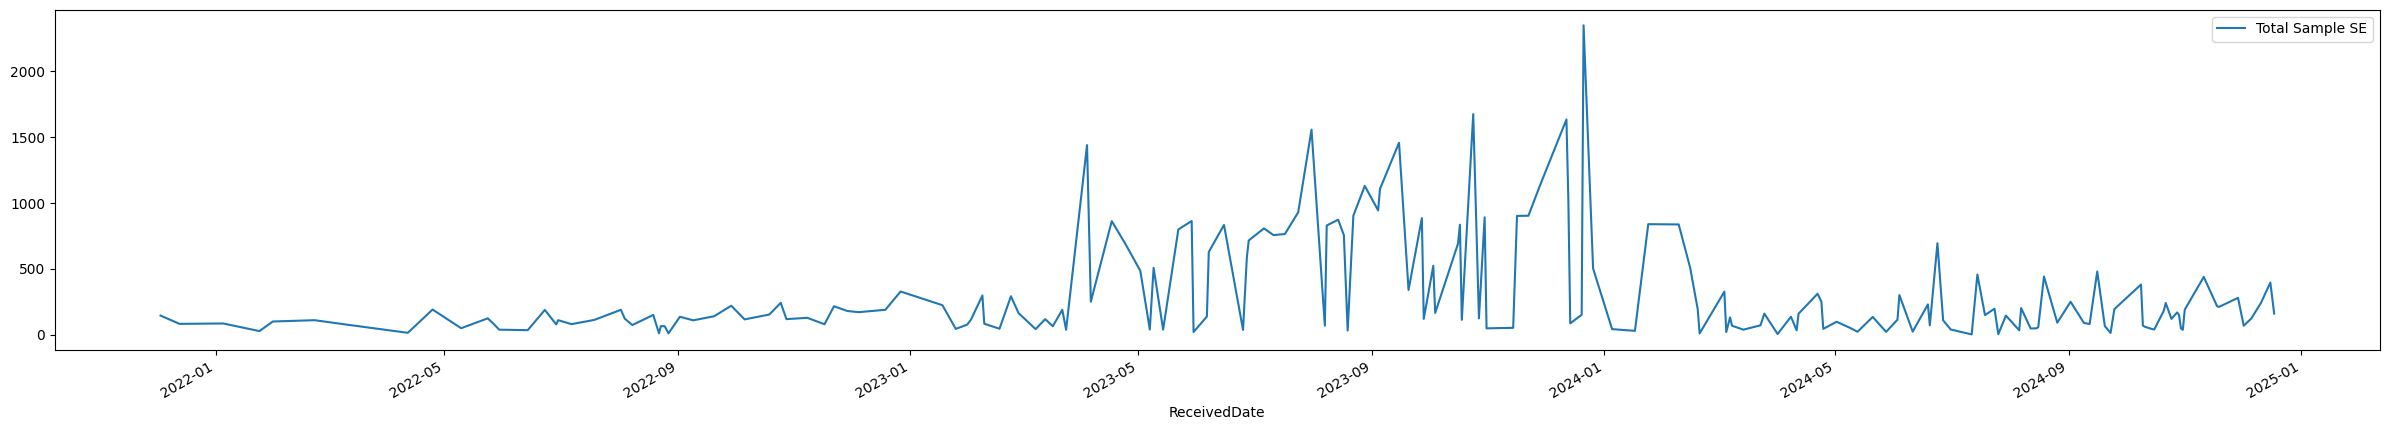

In [34]:
# Agrupamos la sumatoria de TotalSample_SE en las mismas fechas
df_receiveddate_agrupado = df_receiveddate.groupby('ReceivedDate').sum()
print(df_receiveddate_agrupado.head(5))

# Graficamos
df_receiveddate_agrupado.plot(figsize=(30, 5))

In [35]:
df_resultdate =df[['Total Sample SE', 'ResultDate']]
print(df_resultdate.head(5))
print(df_resultdate.dtypes)

   Total Sample SE ResultDate
0                2 2022-07-04
1                4 2022-08-11
2               13 2022-08-05
3               10 2022-08-03
4                8 2022-08-30
Total Sample SE             int64
ResultDate         datetime64[ns]
dtype: object


            Total Sample SE
ResultDate                 
2022-01-20              144
2022-02-07               81
2022-02-19               84
2022-02-28                6
2022-03-01               11


<Axes: xlabel='ResultDate'>

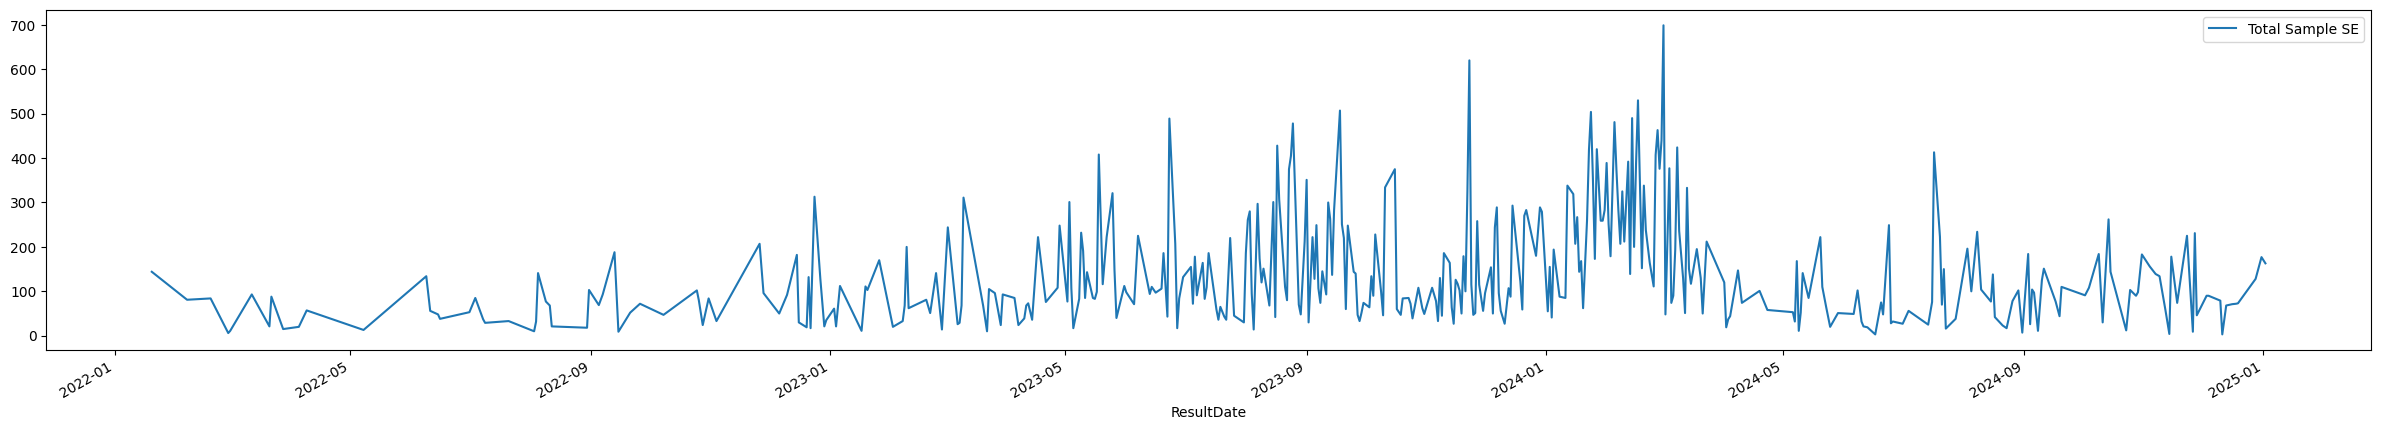

In [36]:
# Se agrupa la sumatoria de TotalSample_SE en las mismas fechas
df_resultdate_agrupado = df_resultdate.groupby('ResultDate').sum()
print(df_resultdate_agrupado.head(5))
#graficamos
df_resultdate_agrupado.plot(figsize=(30, 5))

PASO 5 

In [ ]:

# Asegurarse de que el paquete 'nixtla' esté instalado
try:
    from nixtla import NixtlaClient
except ModuleNotFoundError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "nixtla"])
    from nixtla import NixtlaClient

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Inicializar el cliente de Nixtla con tu clave API
nixtla_client = NixtlaClient(api_key='nixak-h8iV80neQevJ6Zea6Vvw5QtyhIK6ADThKjuvDgp8jVZJiqlnO8C9PyKydKrMxRokzGynSddzUG30T4rc')

# Definir una función para predecir una serie temporal
def forecast_time_series(dataframe, date_col, target_col, horizon=30, freq='D'):
    # Asegurarse de que las fechas estén en formato datetime
    dataframe[date_col] = pd.to_datetime(dataframe[date_col])

    # Preparar los datos para TimeGPT
    forecast_df = nixtla_client.forecast(
        dataframe,
        h=horizon,
        freq=freq,
        time_col=date_col,
        target_col=target_col
    )
    return forecast_df

# Definir una función para evaluar la efectividad del pronóstico
def evaluate_forecast(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    
    return {
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse
    }

# Definir una función para rellenar fechas faltantes y agregar continuidad en la serie temporal
def prepare_time_series(dataframe, date_col, target_col):
    dataframe[date_col] = pd.to_datetime(dataframe[date_col])
    dataframe = dataframe.groupby(date_col).agg({target_col: 'sum'}).reset_index()
    dataframe = dataframe.set_index(date_col).asfreq('D', fill_value=0).reset_index()
    dataframe.columns = ['Date', 'Samples']  # Renombrar las columnas para estandarizar
    return dataframe

# Cargar los datos del archivo
file_path = 'Geochemical Checklist.csv'
data = pd.read_csv(file_path)

# Preparar las series de tiempo reales
#dispatch_time_series = prepare_time_series(data, 'DispatchDate', 'Total Sample SE')
#received_time_series = prepare_time_series(data, 'ReceivedDate', 'Total Sample SE')
#result_time_series = prepare_time_series(data, 'ResultDate', 'Total Sample SE')

# Usar los DataFrames agrupados existentes
dispatch_time_series = prepare_time_series(df_dispatchdate_agrupado.reset_index(), 'DispatchDate', 'Total Sample SE')
received_time_series = prepare_time_series(df_receiveddate_agrupado.reset_index(), 'ReceivedDate', 'Total Sample SE')
result_time_series = prepare_time_series(df_resultdate_agrupado.reset_index(), 'ResultDate', 'Total Sample SE')

# Preparar las tres series de tiempo
series_dict = {
    "DispatchDate": dispatch_time_series,
    "ReceivedDate": received_time_series,
    "ResultDate": result_time_series
}

# Pronosticar para las tres series
forecasts = {}
for series_name, series_data in series_dict.items():
    forecast = forecast_time_series(
        series_data,  # Ya contiene datos rellenados y uniformes
        date_col="Date",
        target_col="Samples"
    )
    forecasts[series_name] = forecast

    # Verificar el contenido del pronóstico
    print(f"Contenido del pronóstico para {series_name}:")
    print(forecast.head())

    # Evaluar la efectividad del pronóstico (si se tienen datos reales para comparar)
    if 'forecast' in forecast.columns:
        if len(series_data) > len(forecast):
            actual = series_data.iloc[-len(forecast):]['Samples']
            predicted = forecast['forecast']
            metrics = evaluate_forecast(actual, predicted)

            print(f"Efectividad del pronóstico para {series_name}:")
            print(metrics)

    # Mostrar resultados
    print(f"Pronóstico para {series_name}:")
    print(forecast.head())



INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Querying model metadata...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


Contenido del pronóstico para DispatchDate:
        Date    TimeGPT
0 2024-12-20  35.795490
1 2024-12-21  23.133970
2 2024-12-22  26.894438
3 2024-12-23  46.337574
4 2024-12-24  42.279780
Pronóstico para DispatchDate:
        Date    TimeGPT
0 2024-12-20  35.795490
1 2024-12-21  23.133970
2 2024-12-22  26.894438
3 2024-12-23  46.337574
4 2024-12-24  42.279780


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


Contenido del pronóstico para ReceivedDate:
        Date    TimeGPT
0 2024-12-19  68.428520
1 2024-12-20  59.615143
2 2024-12-21  54.368470
3 2024-12-22  50.825157
4 2024-12-23  54.295450
Pronóstico para ReceivedDate:
        Date    TimeGPT
0 2024-12-19  68.428520
1 2024-12-20  59.615143
2 2024-12-21  54.368470
3 2024-12-22  50.825157
4 2024-12-23  54.295450
Contenido del pronóstico para ResultDate:
        Date    TimeGPT
0 2025-01-03  39.733730
1 2025-01-04  31.618368
2 2025-01-05  31.107548
3 2025-01-06  35.301483
4 2025-01-07  38.877495
Pronóstico para ResultDate:
        Date    TimeGPT
0 2025-01-03  39.733730
1 2025-01-04  31.618368
2 2025-01-05  31.107548
3 2025-01-06  35.301483
4 2025-01-07  38.877495


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Querying model metadata...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...



📈 Pronóstico para DispatchDate:
        Date    TimeGPT
0 2024-12-20  35.795490
1 2024-12-21  23.133970
2 2024-12-22  26.894438
3 2024-12-23  46.337574
4 2024-12-24  42.279780
📊 Métricas para DispatchDate: {'MAE': 61.783279466666656, 'MSE': 5667.303785722334, 'RMSE': np.float64(75.2814969678628)}


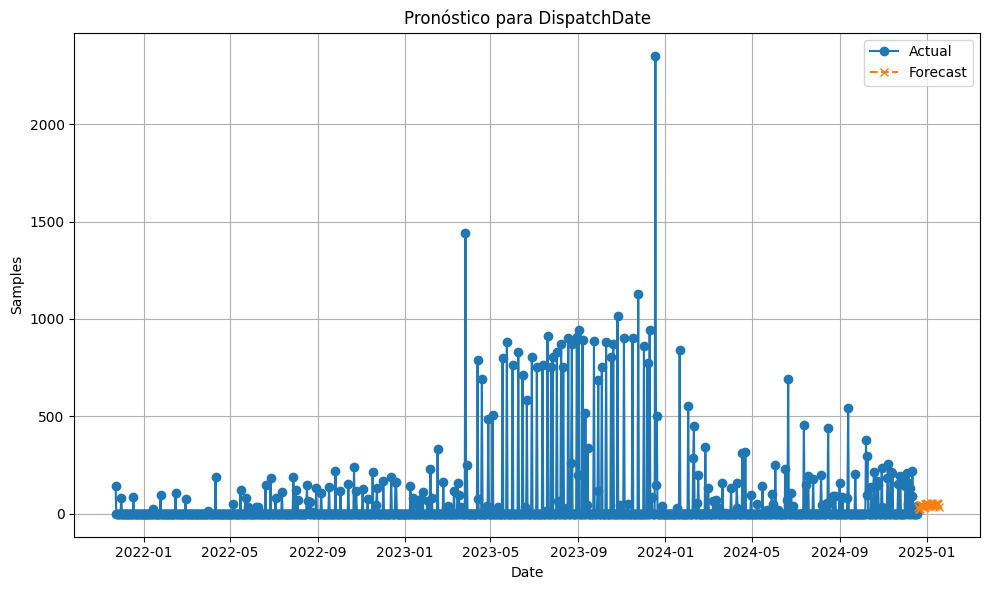

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...



📈 Pronóstico para ReceivedDate:
        Date    TimeGPT
0 2024-12-19  68.428520
1 2024-12-20  59.615143
2 2024-12-21  54.368470
3 2024-12-22  50.825157
4 2024-12-23  54.295450
📊 Métricas para ReceivedDate: {'MAE': 83.15975279999999, 'MSE': 10292.065784401642, 'RMSE': np.float64(101.4498190456821)}


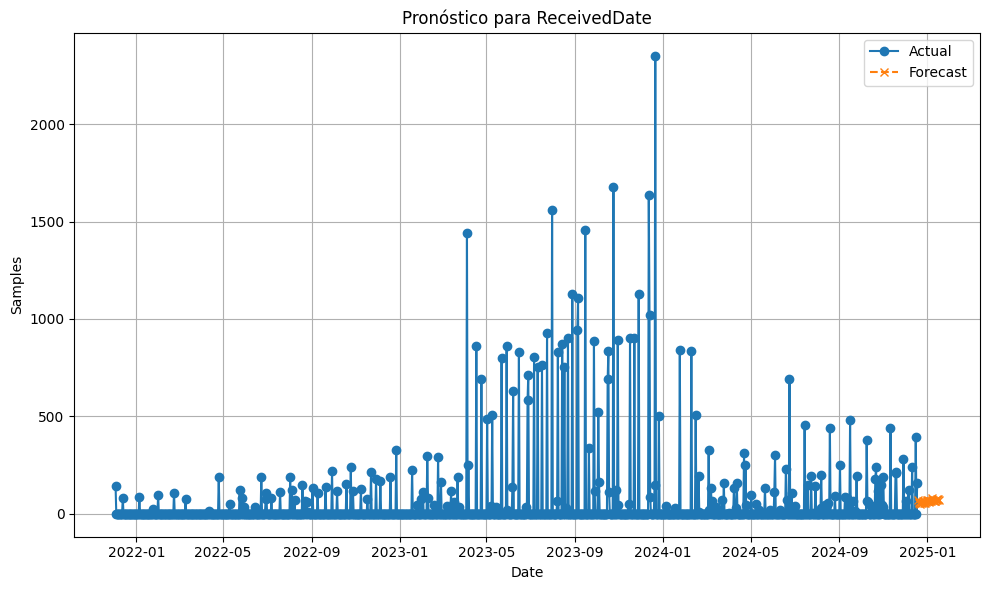

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...



📈 Pronóstico para ResultDate:
        Date    TimeGPT
0 2025-01-03  39.733730
1 2025-01-04  31.618368
2 2025-01-05  31.107548
3 2025-01-06  35.301483
4 2025-01-07  38.877495
📊 Métricas para ResultDate: {'MAE': 45.92317576666667, 'MSE': 2635.198693669715, 'RMSE': np.float64(51.33418640311459)}


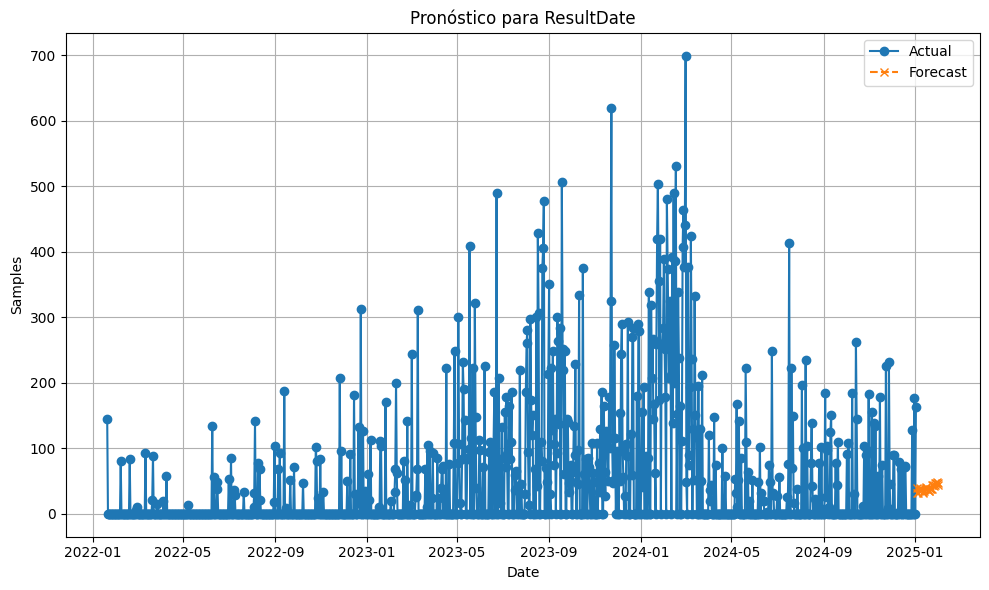

In [39]:
import pandas as pd
import subprocess
import sys
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Asegurarse de que el paquete 'nixtla' esté instalado
try:
    from nixtla import NixtlaClient
except ModuleNotFoundError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "nixtla"])
    from nixtla import NixtlaClient


# Inicializar el cliente de Nixtla con tu clave API
nixtla_client = NixtlaClient(api_key='nixak-h8iV80neQevJ6Zea6Vvw5QtyhIK6ADThKjuvDgp8jVZJiqlnO8C9PyKydKrMxRokzGynSddzUG30T4rc')

# Función para predecir series temporales
def forecast_time_series(dataframe, date_col, target_col, horizon=30, freq='D'):
    dataframe[date_col] = pd.to_datetime(dataframe[date_col])
    forecast_df = nixtla_client.forecast(
        dataframe,
        h=horizon,
        freq=freq,
        time_col=date_col,
        target_col=target_col
    )
    return forecast_df

# Función para evaluar los resultados del pronóstico
def evaluate_forecast(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    return {"MAE": mae, "MSE": mse, "RMSE": rmse}

# Función para asegurar continuidad temporal
def prepare_time_series(dataframe, date_col, target_col, freq='D'):
    dataframe[date_col] = pd.to_datetime(dataframe[date_col])
    dataframe = dataframe.groupby(date_col).agg({target_col: 'sum'}).reset_index()
    full_date_range = pd.date_range(start=dataframe[date_col].min(), end=dataframe[date_col].max(), freq=freq)
    dataframe = dataframe.set_index(date_col).reindex(full_date_range, fill_value=0).reset_index()
    dataframe.columns = ['Date', 'Samples']
    return dataframe

# Función para graficar los resultados
def plot_forecast(series_data, forecast, title):
    plt.figure(figsize=(10, 6))
    plt.plot(series_data['Date'], series_data['Samples'], label='Actual', marker='o')
    plt.plot(forecast['Date'], forecast['TimeGPT'], label='Forecast', linestyle='--', marker='x')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Samples')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

# Usar los DataFrames agrupados existentes
dispatch_time_series = prepare_time_series(df_dispatchdate_agrupado.reset_index(), 'DispatchDate', 'Total Sample SE')
received_time_series = prepare_time_series(df_receiveddate_agrupado.reset_index(), 'ReceivedDate', 'Total Sample SE')
result_time_series = prepare_time_series(df_resultdate_agrupado.reset_index(), 'ResultDate', 'Total Sample SE')

# Armar el diccionario de series
series_dict = {
    "DispatchDate": dispatch_time_series,
    "ReceivedDate": received_time_series,
    "ResultDate": result_time_series
}

# Ejecutar pronóstico con TimeGPT para cada serie
forecasts = {}
for series_name, series_data in series_dict.items():
    forecast = forecast_time_series(
        series_data,
        date_col="Date",
        target_col="Samples"
    )
    forecasts[series_name] = forecast

    print(f"\n📈 Pronóstico para {series_name}:")
    print(forecast.head())

    if 'TimeGPT' in forecast.columns:
        actual = series_data['Samples'][-len(forecast):]
        predicted = forecast['TimeGPT']
        metrics = evaluate_forecast(actual, predicted)
        print(f"📊 Métricas para {series_name}: {metrics}")

        plot_forecast(series_data, forecast, f"Pronóstico para {series_name}")


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Querying model metadata...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


Contenido del pronóstico para DispatchDate:
        Date    TimeGPT
0 2024-12-20  35.795490
1 2024-12-21  23.133970
2 2024-12-22  26.894438
3 2024-12-23  46.337574
4 2024-12-24  42.279780
Efectividad del pronóstico para DispatchDate: {'MAE': 54.90485599999998, 'MSE': 5304.7981614555265, 'RMSE': np.float64(72.83404534594743)}


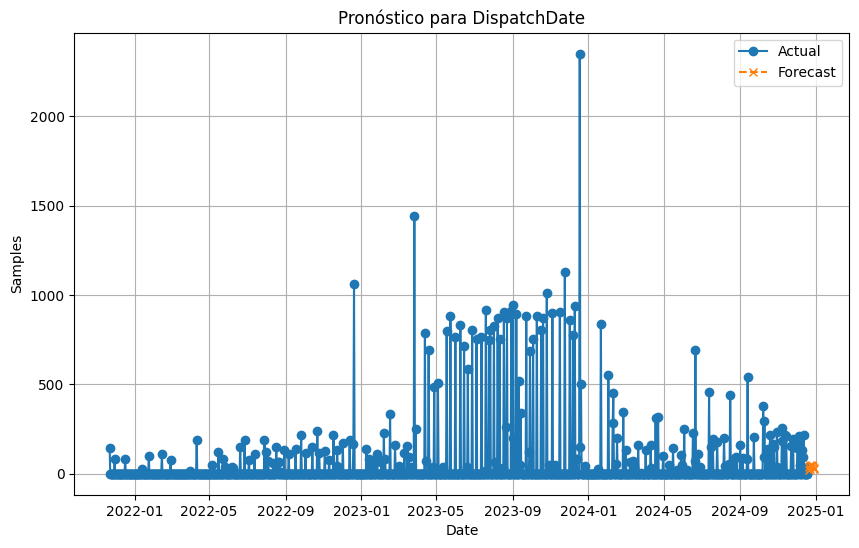

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


Contenido del pronóstico para ReceivedDate:
        Date    TimeGPT
0 2024-12-19  68.428520
1 2024-12-20  59.615143
2 2024-12-21  54.368470
3 2024-12-22  50.825157
4 2024-12-23  54.295450
Efectividad del pronóstico para ReceivedDate: {'MAE': 103.01761689999998, 'MSE': 17725.18684692389, 'RMSE': np.float64(133.1359712734462)}


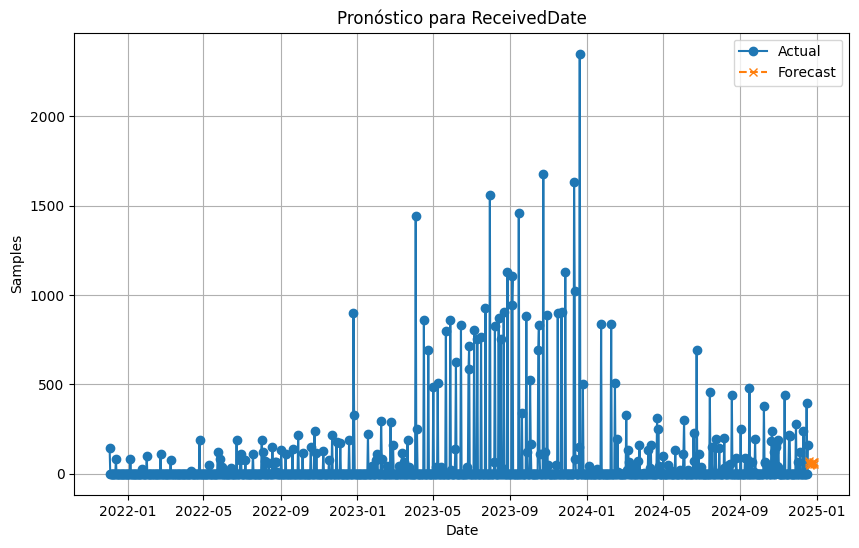

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


Contenido del pronóstico para ResultDate:
        Date    TimeGPT
0 2025-01-03  39.733730
1 2025-01-04  31.618368
2 2025-01-05  31.107548
3 2025-01-06  35.301483
4 2025-01-07  38.877495
Efectividad del pronóstico para ResultDate: {'MAE': 60.5034525, 'MSE': 5306.081490803781, 'RMSE': np.float64(72.84285476835583)}


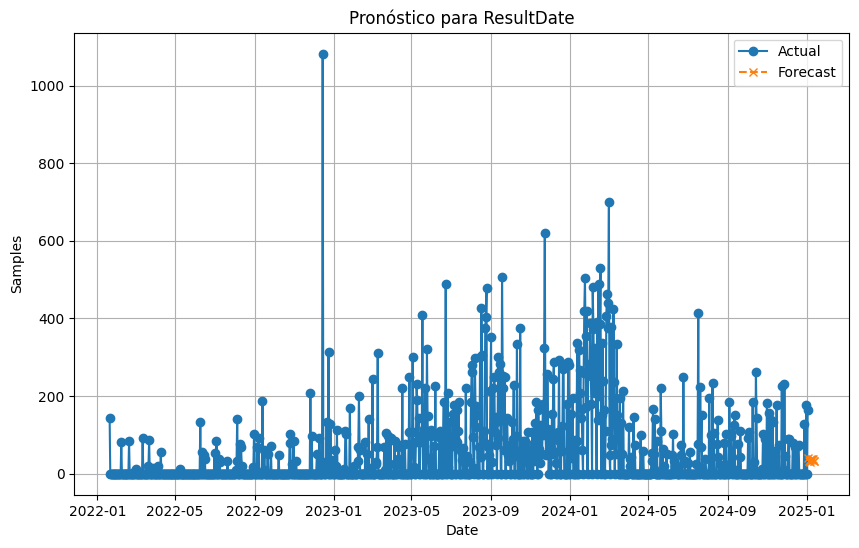

In [40]:
import pandas as pd
import subprocess
import sys
import matplotlib.pyplot as plt

# Asegurarse de que el paquete 'nixtla' esté instalado
try:
    from nixtla import NixtlaClient
except ModuleNotFoundError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "nixtla"])
    from nixtla import NixtlaClient

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Inicializar el cliente de Nixtla con tu clave API
nixtla_client = NixtlaClient(api_key='nixak-h8iV80neQevJ6Zea6Vvw5QtyhIK6ADThKjuvDgp8jVZJiqlnO8C9PyKydKrMxRokzGynSddzUG30T4rc')

# Definir una función para predecir una serie temporal
def forecast_time_series(dataframe, date_col, target_col, horizon=10, freq='D'):
    # Asegurarse de que las fechas estén en formato datetime
    dataframe[date_col] = pd.to_datetime(dataframe[date_col])

    # Preparar los datos para TimeGPT
    forecast_df = nixtla_client.forecast(
        dataframe,
        h=horizon,
        freq=freq,
        time_col=date_col,
        target_col=target_col
    )
    return forecast_df

# Definir una función para evaluar la efectividad del pronóstico
def evaluate_forecast(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    
    return {
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse
    }

# Definir una función para rellenar fechas faltantes y agregar continuidad en la serie temporal
def prepare_time_series(dataframe, date_col, target_col):
    dataframe[date_col] = pd.to_datetime(dataframe[date_col])
    dataframe = dataframe.groupby(date_col).agg({target_col: 'sum'}).reset_index()
    dataframe = dataframe.set_index(date_col).asfreq('D', fill_value=0).reset_index()
    dataframe.columns = ['Date', 'Samples']  # Renombrar las columnas para estandarizar
    return dataframe

# Definir una función para graficar resultados
def plot_forecast(series_data, forecast, title):
    plt.figure(figsize=(10, 6))
    plt.plot(series_data['Date'], series_data['Samples'], label='Actual', marker='o')
    plt.plot(forecast['Date'], forecast['TimeGPT'], label='Forecast', linestyle='--', marker='x')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Samples')
    plt.legend()
    plt.grid()
    plt.show()

# Cargar los datos del archivo
#file_path = 'Geochemical Checklist.csv'
#data = pd.read_csv(file_path)

# Usar los DataFrames agrupados existentes
dispatch_time_series = prepare_time_series(df_dispatchdate_agrupado.reset_index(), 'DispatchDate', 'Total Sample SE')
received_time_series = prepare_time_series(df_receiveddate_agrupado.reset_index(), 'ReceivedDate', 'Total Sample SE')
result_time_series = prepare_time_series(df_resultdate_agrupado.reset_index(), 'ResultDate', 'Total Sample SE')

# Preparar las series de tiempo reales
dispatch_time_series = prepare_time_series(data, 'DispatchDate', 'Total Sample SE')
received_time_series = prepare_time_series(data, 'ReceivedDate', 'Total Sample SE')
result_time_series = prepare_time_series(data, 'ResultDate', 'Total Sample SE')

# Preparar las tres series de tiempo
series_dict = {
    "DispatchDate": dispatch_time_series,
    "ReceivedDate": received_time_series,
    "ResultDate": result_time_series
}

# Pronosticar para las tres series
forecasts = {}
for series_name, series_data in series_dict.items():
    forecast = forecast_time_series(
        series_data,  # Ya contiene datos rellenados y uniformes
        date_col="Date",
        target_col="Samples"
    )
    forecasts[series_name] = forecast

    # Verificar el contenido del pronóstico
    print(f"Contenido del pronóstico para {series_name}:")
    print(forecast.head())

    # Evaluar la efectividad del pronóstico (si se tienen datos reales para comparar)
    if 'TimeGPT' in forecast.columns:
        actual = series_data['Samples'][-len(forecast):]
        predicted = forecast['TimeGPT']
        metrics = evaluate_forecast(actual, predicted)

        print(f"Efectividad del pronóstico para {series_name}: {metrics}")

    # Graficar resultados
    plot_forecast(series_data, forecast, f"Pronóstico para {series_name}")

# Nota: Reemplaza 'nixak-h8iV80neQevJ6Zea6Vvw5QtyhIK6ADThKjuvDgp8jVZJiqlnO8C9PyKydKrMxRokzGynSddzUG30T4rc' con tu clave de TimeGPT para que el código funcione correctamente.


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Querying model metadata...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


Contenido del pronóstico para DispatchDate:
        Date    TimeGPT
0 2024-12-20  50.497880
1 2024-12-21  40.203407
2 2024-12-22  43.716507
3 2024-12-23  59.829030
4 2024-12-24  52.598778
Efectividad del pronóstico para DispatchDate: {'MAE': 66.638818, 'MSE': 6054.019046890374, 'RMSE': np.float64(77.80757705320462)}


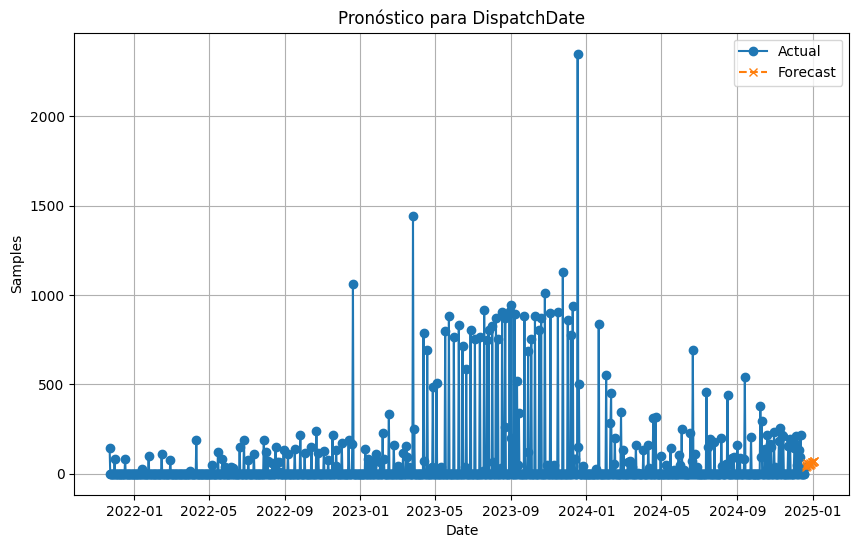

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


Contenido del pronóstico para ReceivedDate:
        Date    TimeGPT
0 2024-12-19  69.823784
1 2024-12-20  54.705395
2 2024-12-21  48.858707
3 2024-12-22  45.609210
4 2024-12-23  51.930084
Efectividad del pronóstico para ReceivedDate: {'MAE': 89.44824039999999, 'MSE': 12110.568233145876, 'RMSE': np.float64(110.04802693890461)}


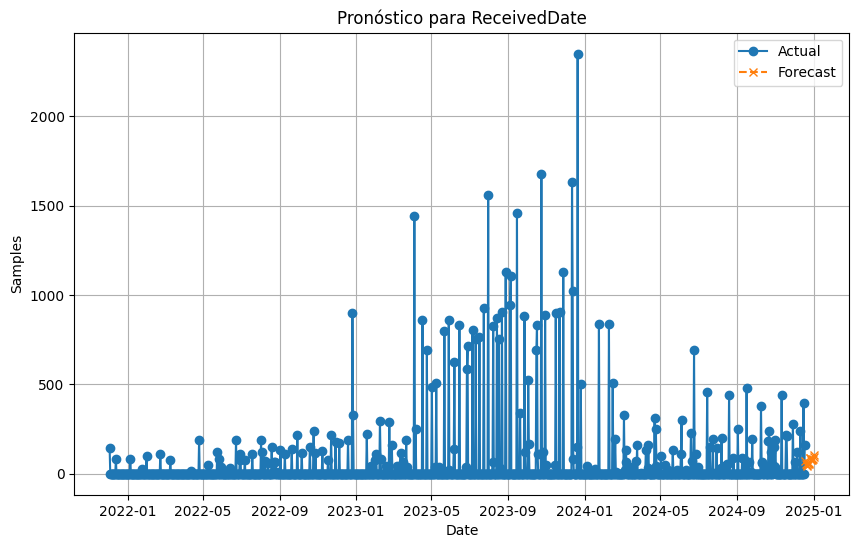

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


Contenido del pronóstico para ResultDate:
        Date    TimeGPT
0 2025-01-03  46.451897
1 2025-01-04  37.799225
2 2025-01-05  38.447224
3 2025-01-06  42.783080
4 2025-01-07  48.528698
Efectividad del pronóstico para ResultDate: {'MAE': 57.65305346666666, 'MSE': 3807.7539171316002, 'RMSE': np.float64(61.7070005520573)}


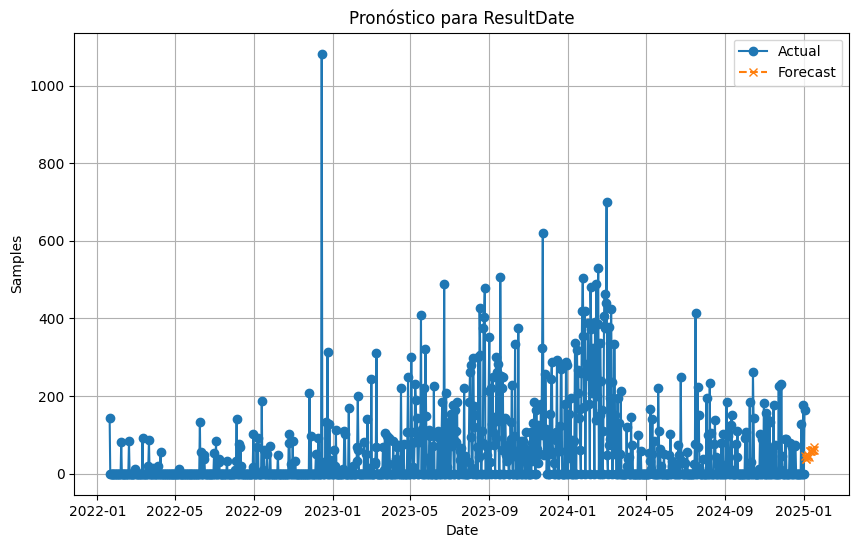

In [41]:
import pandas as pd
import subprocess
import sys
import matplotlib.pyplot as plt

# Asegurarse de que el paquete 'nixtla' esté instalado
try:
    from nixtla import NixtlaClient
except ModuleNotFoundError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "nixtla"])
    from nixtla import NixtlaClient

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Inicializar el cliente de Nixtla con tu clave API
nixtla_client = NixtlaClient(api_key='nixak-h8iV80neQevJ6Zea6Vvw5QtyhIK6ADThKjuvDgp8jVZJiqlnO8C9PyKydKrMxRokzGynSddzUG30T4rc')

# Definir una función para predecir una serie temporal
# Se agregan parámetros para ajustar el modelo de TimeGPT
def forecast_time_series(dataframe, date_col, target_col, horizon=30, freq='D', model='timegpt-1', finetune_steps=10):
    # Asegurarse de que las fechas estén en formato datetime
    dataframe[date_col] = pd.to_datetime(dataframe[date_col])

    # Preparar los datos para TimeGPT con ajustes avanzados
    forecast_df = nixtla_client.forecast(
        dataframe,
        h=horizon,
        freq=freq,
        time_col=date_col,
        target_col=target_col,
        model=model,  # Modelo que se va a usar
        finetune_steps=finetune_steps,  # Pasos para el ajuste fino del modelo
        finetune_loss='mse'  # Usar MSE como función de pérdida para optimizar
    )
    return forecast_df

# Definir una función para evaluar la efectividad del pronóstico
def evaluate_forecast(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    
    return {
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse
    }

# Definir una función para rellenar fechas faltantes y agregar continuidad en la serie temporal
def prepare_time_series(dataframe, date_col, target_col):
    dataframe[date_col] = pd.to_datetime(dataframe[date_col])
    dataframe = dataframe.groupby(date_col).agg({target_col: 'sum'}).reset_index()
    dataframe = dataframe.set_index(date_col).asfreq('D', fill_value=0).reset_index()
    dataframe.columns = ['Date', 'Samples']  # Renombrar las columnas para estandarizar
    return dataframe

# Definir una función para graficar resultados
def plot_forecast(series_data, forecast, title):
    plt.figure(figsize=(10, 6))
    plt.plot(series_data['Date'], series_data['Samples'], label='Actual', marker='o')
    plt.plot(forecast['Date'], forecast['TimeGPT'], label='Forecast', linestyle='--', marker='x')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Samples')
    plt.legend()
    plt.grid()
    plt.show()

# Cargar los datos del archivo
#file_path = 'Geochemical Checklist.csv'
#data = pd.read_csv(file_path)

# Usar los DataFrames agrupados existentes
dispatch_time_series = prepare_time_series(df_dispatchdate_agrupado.reset_index(), 'DispatchDate', 'Total Sample SE')
received_time_series = prepare_time_series(df_receiveddate_agrupado.reset_index(), 'ReceivedDate', 'Total Sample SE')
result_time_series = prepare_time_series(df_resultdate_agrupado.reset_index(), 'ResultDate', 'Total Sample SE')

# Preparar las series de tiempo reales
dispatch_time_series = prepare_time_series(data, 'DispatchDate', 'Total Sample SE')
received_time_series = prepare_time_series(data, 'ReceivedDate', 'Total Sample SE')
result_time_series = prepare_time_series(data, 'ResultDate', 'Total Sample SE')

# Preparar las tres series de tiempo
series_dict = {
    "DispatchDate": dispatch_time_series,
    "ReceivedDate": received_time_series,
    "ResultDate": result_time_series
}

# Pronosticar para las tres series
forecasts = {}
for series_name, series_data in series_dict.items():
    forecast = forecast_time_series(
        series_data,  # Ya contiene datos rellenados y uniformes
        date_col="Date",
        target_col="Samples",
        horizon=15,  # Reducir el horizonte para mejorar precisión
        finetune_steps=20  # Más pasos de ajuste fino
    )
    forecasts[series_name] = forecast

    # Verificar el contenido del pronóstico
    print(f"Contenido del pronóstico para {series_name}:")
    print(forecast.head())

    # Evaluar la efectividad del pronóstico (si se tienen datos reales para comparar)
    if 'TimeGPT' in forecast.columns:
        actual = series_data['Samples'][-len(forecast):]
        predicted = forecast['TimeGPT']
        metrics = evaluate_forecast(actual, predicted)

        print(f"Efectividad del pronóstico para {series_name}: {metrics}")

    # Graficar resultados
    plot_forecast(series_data, forecast, f"Pronóstico para {series_name}")

# Nota: Reemplaza 'nixak-h8iV80neQevJ6Zea6Vvw5QtyhIK6ADThKjuvDgp8jVZJiqlnO8C9PyKydKrMxRokzGynSddzUG30T4rc' con tu clave de TimeGPT para que el código funcione correctamente.

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


Pronóstico para DispatchDate:
        Date    TimeGPT
0 2024-12-20  50.638650
1 2024-12-21  40.303917
2 2024-12-22  43.634075
3 2024-12-23  59.709310
4 2024-12-24  52.495983
Evaluación para DispatchDate: {'MAE': 66.52090546666668, 'MSE': 6040.195773210219, 'RMSE': np.float64(77.71869641991056)}


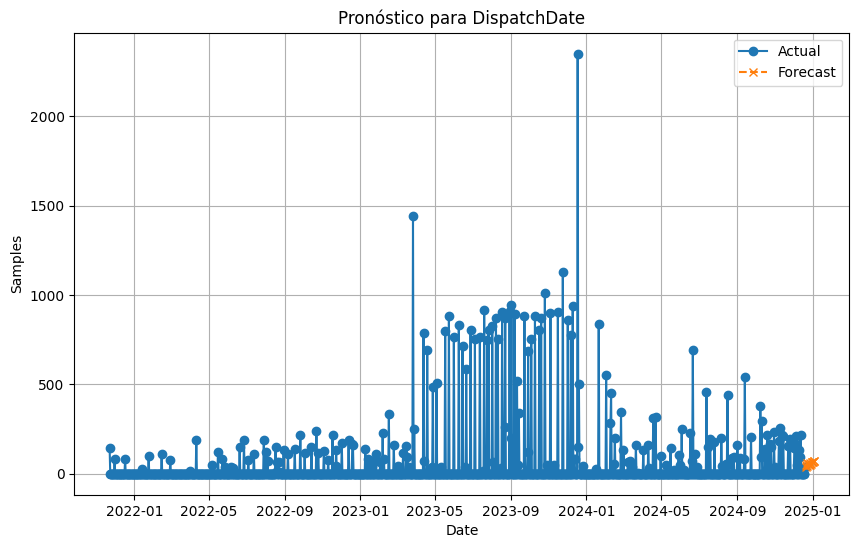

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


Pronóstico para ReceivedDate:
        Date    TimeGPT
0 2024-12-19  66.982290
1 2024-12-20  50.927647
2 2024-12-21  45.840350
3 2024-12-22  42.396336
4 2024-12-23  48.053024
Evaluación para ReceivedDate: {'MAE': 88.07640013333334, 'MSE': 12009.906203650526, 'RMSE': np.float64(109.58971760001266)}


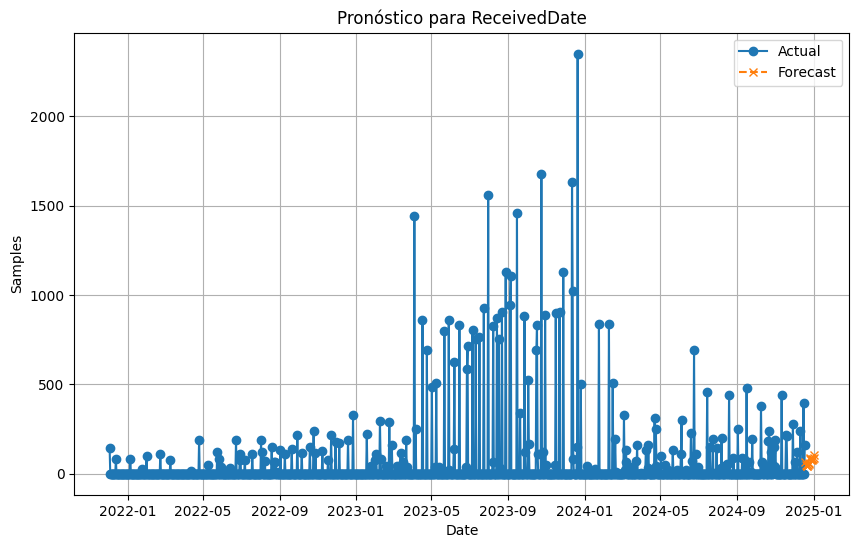

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


Pronóstico para ResultDate:
        Date    TimeGPT
0 2025-01-03  45.806130
1 2025-01-04  37.003323
2 2025-01-05  37.770840
3 2025-01-06  41.915000
4 2025-01-07  47.437630
Evaluación para ResultDate: {'MAE': 57.27500286666667, 'MSE': 3780.728996313795, 'RMSE': np.float64(61.48763287291027)}


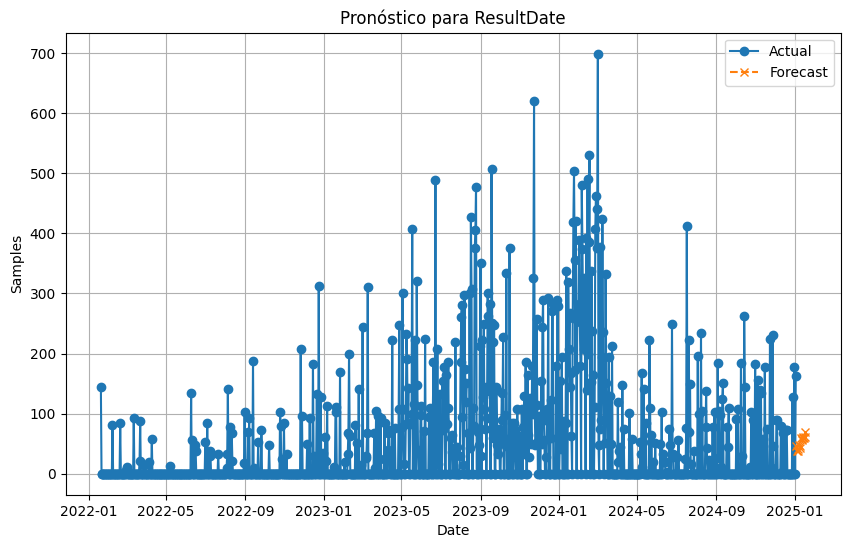

In [42]:

# Usamos los DataFrames agrupados ya existentes y rellenamos las fechas faltantes
def preprocess_time_series(df, date_col, target_col, freq='D'):
    df = df.reset_index()
    df.columns = [date_col, target_col]
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.set_index(date_col).asfreq(freq, fill_value=0).reset_index()
    return df

dispatch_time_series = preprocess_time_series(df_dispatchdate_agrupado, 'Date', 'Samples')
received_time_series = preprocess_time_series(df_receiveddate_agrupado, 'Date', 'Samples')
result_time_series = preprocess_time_series(df_resultdate_agrupado, 'Date', 'Samples')

# Diccionario con todas las series
series_dict = {
    "DispatchDate": dispatch_time_series,
    "ReceivedDate": received_time_series,
    "ResultDate": result_time_series
}

# Pronosticar para las tres series con TimeGPT
forecasts = {}
for series_name, series_data in series_dict.items():
    forecast = forecast_time_series(
        series_data,
        date_col="Date",
        target_col="Samples",
        horizon=15,
        finetune_steps=20
    )
    forecasts[series_name] = forecast

    # Mostrar el pronóstico
    print(f"Pronóstico para {series_name}:")
    print(forecast.head())

    # Evaluar el rendimiento
    if 'TimeGPT' in forecast.columns:
        actual = series_data['Samples'][-len(forecast):]
        predicted = forecast['TimeGPT']
        metrics = evaluate_forecast(actual, predicted)
        print(f"Evaluación para {series_name}: {metrics}")

    # Graficar resultados
    plot_forecast(series_data, forecast, f"Pronóstico para {series_name}")
